In [5]:
import os
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

from diffEq import odes, plot

## Test differential equation:

$\frac{dT(t)}{dt} = r(T_{env} - T(t))$



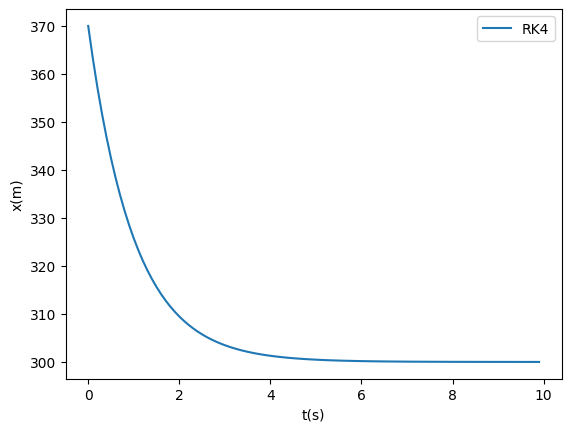

In [6]:
r = 1
T_env = 300

# args = [T]
def DT(t, args):
    return r*(T_env - args[0])

cooling_obj = odes([DT], [370])

t_list, T_list = cooling_obj.solve_Runge_Kutta(0, 10, h=0.1, stage=4)
solutions = {"RK4": (t_list, T_list)}

plot(solutions)

## Getting device for training

In [7]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
    print(device)

cuda


## Preparing data

In [8]:
n_step = 20

torch.manual_seed(0)
r_tensor = torch.rand(100, 1)
T_env_tensor = torch.rand(100, 1) * 500
T_0_tensor = T_env_tensor + torch.rand(100, 1) * 100
t_tensor = torch.linspace(0, 50, n_step)
T_tensor = T_env_tensor - (T_env_tensor - T_0_tensor)*torch.exp(-r_tensor * t_tensor)

# Split data into training and test sets
r_train, T_env_train, T_0_train, T_train = r_tensor[:80], T_env_tensor[:80], T_0_tensor[:80], T_tensor[:80]
X_train = torch.cat((r_train, T_env_train, T_0_train), 1)

X_train_mean = X_train.mean(dim=0, keepdim=True)
X_train_std = X_train.std(dim=0, keepdim=True)
X_train = (X_train - X_train_mean) / X_train_std

r_test, T_env_test, T_0_test, T_test = r_tensor[80:], T_env_tensor[80:], T_0_tensor[80:], T_tensor[80:]
X_test = torch.cat((r_test, T_env_test, T_0_test), 1)

X_test_mean = X_test.mean(dim=0, keepdim=True)
X_test_std = X_test.std(dim=0, keepdim=True)
X_test = (X_test - X_test_mean) / X_test_std

## Defining the model

In [9]:
class CoolingModel(nn.Module):
    def __init__(self, n_step):
        super().__init__()
        self.linear = nn.Linear(in_features=3, out_features=n_step)

    def forward(self, x):
        return self.linear(x)

# Initiate the model
model = CoolingModel(n_step)

In [10]:
# Loss function and optimizer
loss_func = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Train the model

In [15]:
epochs = 100000

for epoch in range(epochs):
    T_pred = model(X_train)
    
    loss = loss_func(T_pred, T_train)

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 100/100000, Loss: 135.2895
Epoch 200/100000, Loss: 134.8825
Epoch 300/100000, Loss: 134.4772
Epoch 400/100000, Loss: 134.0730
Epoch 500/100000, Loss: 133.6706
Epoch 600/100000, Loss: 133.2694
Epoch 700/100000, Loss: 132.8698
Epoch 800/100000, Loss: 132.4713
Epoch 900/100000, Loss: 132.0744
Epoch 1000/100000, Loss: 131.6789
Epoch 1100/100000, Loss: 131.2849
Epoch 1200/100000, Loss: 130.8920
Epoch 1300/100000, Loss: 130.5007
Epoch 1400/100000, Loss: 130.1107
Epoch 1500/100000, Loss: 129.7222
Epoch 1600/100000, Loss: 129.3350
Epoch 1700/100000, Loss: 128.9491
Epoch 1800/100000, Loss: 128.5646
Epoch 1900/100000, Loss: 128.1815
Epoch 2000/100000, Loss: 127.7998
Epoch 2100/100000, Loss: 127.4192
Epoch 2200/100000, Loss: 127.0401
Epoch 2300/100000, Loss: 126.6623
Epoch 2400/100000, Loss: 126.2860
Epoch 2500/100000, Loss: 125.9108
Epoch 2600/100000, Loss: 125.5371
Epoch 2700/100000, Loss: 125.1645
Epoch 2800/100000, Loss: 124.7935
Epoch 2900/100000, Loss: 124.4236
Epoch 3000/100000, Loss

In [16]:
model.eval()
with torch.no_grad():
    T_pred_test = model(X_test)
    test_loss = loss_func(T_pred_test, T_test)
    print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 1164.5309


In [17]:
for name, param in model.named_parameters():
    print(name, param.data)

linear.weight tensor([[  0.1639,  10.6621, 137.2078],
        [-11.0570,  96.8585,  49.4322],
        [ -8.9880, 116.9004,  28.7454],
        [ -6.7170, 124.5278,  20.8783],
        [ -5.1434, 128.4564,  16.8505],
        [ -4.0843, 130.7422,  14.5174],
        [ -3.3536, 132.1592,  13.0877],
        [ -2.8326, 132.9881,  12.2581],
        [ -2.4466, 133.5896,  11.6622],
        [ -2.1520, 133.9685,  11.2931],
        [ -1.9220, 134.0829,  11.1893],
        [ -1.7338, 134.2702,  11.0150],
        [ -1.5774, 134.4230,  10.8753],
        [ -1.4454, 134.4944,  10.8161],
        [ -1.3310, 134.5896,  10.7330],
        [ -1.2321, 134.5769,  10.7561],
        [ -1.1436, 134.6344,  10.7091],
        [ -1.0657, 134.6096,  10.7429],
        [ -0.9941, 134.6845,  10.6773],
        [ -0.9311, 134.6325,  10.7370]])
linear.bias tensor([273.4877, 241.8272, 233.8171, 230.7203, 229.1415, 228.2083, 227.6084,
        227.2000, 226.9091, 226.6936, 226.5283, 226.3973, 226.2906, 226.2016,
        226.1259,

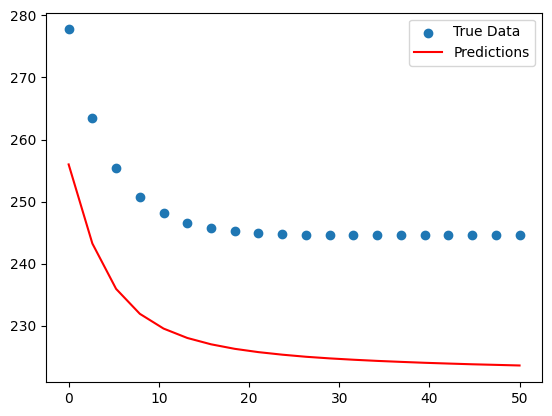

In [18]:
plt.scatter(t_tensor, T_test[-1], label="True Data")
plt.plot(t_tensor, T_pred_test[-1], color="red", label="Predictions")
plt.legend()
plt.show()